In [1]:
%matplotlib inline
%load_ext rpy2.ipython


import datetime as dt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm
from pykalman import KalmanFilter
import numpy.ma as ma
import scipy.linalg as linalg
import scipy as sp
import statsmodels.api as sm
import statsmodels.tsa as tsa
import os.path
import pickle
import scipy as sp
from scipy.optimize import minimize

import matplotlib.pyplot as plt

from numpy.linalg import inv
from numpy.linalg import det

from scipy.stats import norm
from scipy.stats import chi2

from pykalman import KalmanFilter as pykalman_KF
from numpy import ma

# pd.set_option('max_rows', 20)
pd.set_option('max_rows', 100)

dataDetailsSheet = "Plan2"

picklesDir = "./Pickles/"
%load_ext autotime

# Data

## Regressors

In [2]:
data = pd.read_excel("Nowcasting.xlsx",sheetname="Valores")
# data.head()
series = data.loc[0,:][~data.loc[0,:].isnull()].tolist()
data.columns = data.iloc[0]

time: 1.88 s


In [3]:
# i=data.columns.get_loc("MXWO Index")
# data.iloc[1:,i:i+2]

dfsList = []

for serie in series:
    i = data.columns.get_loc(serie)
    df = data.iloc[1:,i:i+2]
    df.set_index(serie,inplace=True)
    df.columns = [serie]
    df = df.loc[~df.index.duplicated(keep='first')]
    if not df[serie].isnull().all():
        dfsList.append(df.apply(pd.to_numeric))

data = pd.concat(dfsList,axis=1)
data.sort_index(inplace=True)
if data.loc[data.index[-1]].notnull().any() == False:
    data.drop(data.index[-1],inplace=True)
data.tail()

C:\Anaconda3\lib\site-packages\pandas\indexes\base.py:1877: FutureWarning: In the future, 'NAT < x' and 'x < NAT' will always be False.
  self._values[0] < other_diff[0]


,BZGDINDX Index,BZGDGNDI Index,BZGDFNCE Index,BZIPTLYo Index,BZUETOTN Index,BFOETTOD Index,MPMIBRMA Index,BZREELHT Index,BPPICM Index,BZPIIPCM Index,...,BZEASA INDEX,OEBRD003 INDEX,BZGDYOY% Index,BZGDQOQ Index,BZIPTLSA Index,BRLFUNRT Index,BFOETTSA Index,BZPIIPCY Index,BZRTRETM Index,BZJCTOTS Index
2017-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 208 ms


In [4]:
data.loc[data.index[-1]].notnull().any()

True

time: 3.01 ms


### Select Sample 

In [5]:
# data["BZRTRETM Index"].dropna().plot()

time: 4.01 ms


In [6]:
gdpTicker = "BZGDYOY% Index"
listOfCols = [
    "BZGDYOY% Index",
#     "BZGDGNDI Index",
#     "BZGDFNCE Index",
    "BZIPTLSA Index",
    "MPMIBRMA Index",
    "BFOETTSA Index",
    "BZREELHT Index",
    "BZPIIPCY Index",
    "BZPIIPCM Index",
    "BZEXTOT$ Index",
    "BZTBBALY INDEX",
    "BZBXPBCM INDEX",
    "BZRTFBSA INDEX",
    "BZFGCCSA INDEX",
    "ibov index",
    "CL1 Comdty",
    "BCSWLPD CURNCY",
    "bcswfpd curncy",
    "BZMOTRFB INDEX",
    "BZJCTOTS Index",
    "BZEASA INDEX",
    "OEBRD003 INDEX",
    "BZRTRETM Index",
]
data = data[listOfCols]

time: 7.02 ms


In [7]:
data.index.min()

Timestamp('2000-01-05 00:00:00')

time: 6.02 ms


In [8]:
data.index.max()

Timestamp('2017-03-20 00:00:00')

time: 6.02 ms


### Transformations


In [9]:
data.columns

Index(['BZGDYOY% Index', 'BZIPTLSA Index', 'MPMIBRMA Index', 'BFOETTSA Index',
       'BZREELHT Index', 'BZPIIPCY Index', 'BZPIIPCM Index', 'BZEXTOT$ Index',
       'BZTBBALY INDEX', 'BZBXPBCM INDEX', 'BZRTFBSA INDEX', 'BZFGCCSA INDEX',
       'ibov index', 'CL1 Comdty', 'BCSWLPD CURNCY', 'bcswfpd curncy',
       'BZMOTRFB INDEX', 'BZJCTOTS Index', 'BZEASA INDEX', 'OEBRD003 INDEX',
       'BZRTRETM Index'],
      dtype='object')

time: 5.52 ms


In [10]:
transf = pd.read_excel("Nowcasting.xlsx",sheetname=dataDetailsSheet,)
transf.set_index("Code",inplace=True)

time: 1.51 s


In [11]:
for s in transf.index[transf["Log"]==True]:
    if s in data.columns:
        data[s] = data[s].apply(np.log)
    
data = data.resample("M").sum()
    
for s in transf.index[transf["Diff"]==True]:
    if s in data.columns:
        print(s)
        data[s] = data[s].diff()

for s in transf.index[transf["DiffAnnual"]==True]:
    if s in data.columns:
        data[s] = data[s].diff(3)

MPMIBRMA Index
BZREELHT Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZEASA INDEX
OEBRD003 INDEX
BZIPTLSA Index
BFOETTSA Index
BZPIIPCY Index
time: 81.2 ms


C:\Anaconda3\lib\site-packages\pandas\core\algorithms.py:1251: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [12]:
data.replace([np.inf, -np.inf], np.nan,inplace=True)

time: 1.01 ms


### Standardize


In [13]:
mu = data.mean()
sigma = data.std()
data = (data - mu) / sigma

time: 6.02 ms


### Stationarity

In [14]:
# For now we'll drop quarterly series
# data.drop("BZGDGNDI Index",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("ibov index",axis=1,inplace=True)
# data.drop("CL1 Comdty",axis=1,inplace=True)
# data.drop("BCSWLPD CURNCY",axis=1,inplace=True)
# data.drop("bcswfpd curncy",axis=1,inplace=True)
# data.drop("BZEXTOT$ Index",axis=1,inplace=True)
# data.drop("BZTBBALY INDEX",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)
# data.drop("BZGDFNCE Index",axis=1,inplace=True)

time: 5.02 ms


In [15]:
for series in data.columns:
    try:
        d = data[series]   
        print(series)
        pv = sm.tsa.stattools.adfuller(d[d.notnull()])[1]
        if pv > 0.11:
            print(series + " 's p-value is: " + str(pv))
    except:
        print("Error")

BZGDYOY% Index
BZGDYOY% Index 's p-value is: 0.980186983575
BZIPTLSA Index
MPMIBRMA Index
BFOETTSA Index
BZREELHT Index
BZPIIPCY Index
BZPIIPCM Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
Error
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZMOTRFB INDEX
BZJCTOTS Index
BZJCTOTS Index 's p-value is: 0.881793681761
BZEASA INDEX
OEBRD003 INDEX
OEBRD003 INDEX 's p-value is: 0.41382820824
BZRTRETM Index
BZRTRETM Index 's p-value is: 0.417487199324
time: 279 ms


# Dimensions

In [16]:
dataQ = data[[gdpTicker]]
data.drop(gdpTicker,axis=1,inplace=True)

time: 2.01 ms


In [17]:
T = data.shape[0]
T

207

time: 6.52 ms


In [18]:
n = (data.columns | dataQ.columns).shape[0]
n

21

time: 5.01 ms


In [19]:
nm = (data.columns).shape[0]
nm

20

time: 7.02 ms


In [20]:
nq = (dataQ.columns).shape[0]
nq

1

time: 5.51 ms


In [21]:
m = 5 + nm + 5 * nq
m

30

time: 5.52 ms


# Data Matrices

$y$ which is $n \times T$ will be the vertical stack of the monthly and quarterly variables

In [22]:
y = pd.concat([ data.transpose(), dataQ.transpose(),], axis=0)
y.shape

(21, 207)

time: 8.02 ms


# Coefficients

## Z Matrix

The $Z$ matrix is a $n \times m$

In [23]:
coefs = []
for el in data.columns:
    coefs.append(el + "_loading")
lambdaM = pd.DataFrame(coefs)

line1 = lambdaM
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,4)))], axis=1)

line1 = pd.concat([line1, pd.DataFrame(np.identity(nm))], axis=1)
missingDimension = m - line1.shape[1]
line1 = pd.concat([line1, pd.DataFrame(np.zeros((nm,missingDimension)))], axis=1)

line1.shape

coefsZ = coefs

time: 10.5 ms


In [24]:
coefs = []
for el in dataQ.columns:
    coefs.append(el + "_loading")
lambdaQ = pd.DataFrame(coefs)

line2 = lambdaQ
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "3*" + lambdaQ], axis=1)
line2 = pd.concat([line2, "2*" + lambdaQ], axis=1)
line2 = pd.concat([line2, lambdaQ], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.zeros((nq,nm)))], axis=1)

line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 3*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, 2*pd.DataFrame(np.ones((nq,1)))], axis=1)
line2 = pd.concat([line2, pd.DataFrame(np.ones((nq,1)))], axis=1)

coefsZ += coefs

time: 23.6 ms


In [25]:
line1.columns = list(range(0,line1.columns.shape[0]))
line2.columns = list(range(0,line2.columns.shape[0]))

Z = pd.concat([line1,line2], axis=0, ignore_index=True)
Z = Z.apply(pd.to_numeric,1,errors='ignore')
Z = Z.apply(pd.to_numeric,0,errors='ignore')
Z.shape

(21, 30)

time: 22.6 ms


In [26]:
# trying to impose restriction described in p 13-14 about identifying the model
Z.iloc[0,0] = 1
# Z

time: 2.01 ms


In [27]:
coefsZ

['BZIPTLSA Index_loading',
 'MPMIBRMA Index_loading',
 'BFOETTSA Index_loading',
 'BZREELHT Index_loading',
 'BZPIIPCY Index_loading',
 'BZPIIPCM Index_loading',
 'BZEXTOT$ Index_loading',
 'BZTBBALY INDEX_loading',
 'BZBXPBCM INDEX_loading',
 'BZRTFBSA INDEX_loading',
 'BZFGCCSA INDEX_loading',
 'ibov index_loading',
 'CL1 Comdty_loading',
 'BCSWLPD CURNCY_loading',
 'bcswfpd curncy_loading',
 'BZMOTRFB INDEX_loading',
 'BZJCTOTS Index_loading',
 'BZEASA INDEX_loading',
 'OEBRD003 INDEX_loading',
 'BZRTRETM Index_loading',
 'BZGDYOY% Index_loading']

time: 7.52 ms


## B Matrix

$B$ matrix is $m \times m$

In [28]:
bMat = np.array(["A1",0.,0.,0.])
bMat = np.vstack((np.array(bMat),np.identity(4)))
bMat = linalg.block_diag(bMat,np.array([0]))

alphaM = "alphaM_" + pd.DataFrame(data.columns.tolist()).astype(str) 
# alphaM = alphaM.transpose()[0]
alphaM = np.diag(alphaM[0])

bMat = bMat[:-1]

bMat = linalg.block_diag(bMat,alphaM)

alphaQ = "alphaQ_" + pd.DataFrame(dataQ.columns.tolist()).astype(str) 
# alphaQ = alphaQ.transpose()[0]
alphaQ = np.diag(alphaQ[0])

bMat = linalg.block_diag(bMat,alphaQ)

newLine = np.hstack((np.zeros((nq,bMat.shape[1]-nq)),np.identity(nq)))
bMat = np.vstack((bMat,newLine))

bMat = linalg.block_diag(bMat,np.identity(m-bMat.shape[1]-1))
bMat = linalg.block_diag(bMat,np.array([0]))
bMat = bMat[:-1]
B = pd.DataFrame(bMat)
B = B.apply(pd.to_numeric,1,errors='ignore')
B = B.apply(pd.to_numeric,0,errors='ignore')
# alphaM
# newLine
# pd.to_numeric(pd.DataFrame(bMat)[0].iloc[1])
B.shape

(30, 30)

time: 46.1 ms


In [29]:
coefsB = np.array(["A1"])
coefsB = np.append(coefsB,alphaQ)
coefsB = np.append(coefsB,np.diag(alphaM))

time: 1.5 ms


## Q Matrix

$Q_t$ is $m \times m$


In [30]:
coefsU = np.array([])

u = np.array("u_t")
u = np.vstack((u,np.zeros((4,1))))
merrors = "em_" + pd.DataFrame(np.array([list(range(0,nm))])).astype(str)
u = np.vstack((u,merrors.T))

coefsU = np.append(coefsU,merrors)

merrors = "eq_" + pd.DataFrame(np.array([list(range(0,nq))])).astype(str)

coefsU = np.append(coefsU,merrors)

u = np.vstack((u,merrors.T))

u = np.vstack((u,np.zeros((m-u.shape[0],1))))

u = pd.DataFrame(u)

u[0] = pd.to_numeric(u[0],errors='ignore')

idx = np.unique(np.where(u=="0.0" )[0].tolist() + np.where(u==0 )[0].tolist())

time: 15.5 ms


In [31]:
Q = "Q_" + pd.DataFrame([range(0,m)]).astype(str) 
Q = Q.transpose()[0]

coefsQ = np.array(Q)

Q = np.diag(Q)
Q[idx] = 0
Q = pd.DataFrame(Q)
Q.shape

(30, 30)

time: 10 ms


# H Matrix

In [32]:
p = y.shape[0]
H = np.diag(np.repeat("H_diag",p))

H = pd.DataFrame(H)
H = H.apply(pd.to_numeric,1,errors='ignore')
H = H.apply(pd.to_numeric,0,errors='ignore')
H.replace('',0,inplace=True)

time: 22.6 ms


# R Matrix

In [33]:
m = Z.shape[1]
R = np.diag(np.repeat(1,m))

R = pd.DataFrame(R)
R = R.apply(pd.to_numeric,1,errors='ignore')
R = R.apply(pd.to_numeric,0,errors='ignore')
R.replace('',0,inplace=True)

time: 17.5 ms


# Kalman Filter

## Partial Line of Nulls

![KoopmanFactorModel](Figuras_Notebook/FactorModel_Koopman.PNG)

![KoopmanMatrixSizes](Figuras_Notebook/MatrixSizes_Koopman.PNG)

Based on Durbin Koopman


For generic state-space systems like (Hamilton's notation):



$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

Where

* $p$ is the number of observed variables
* $m$ is the number of latent states
* $r$ is the number of disturbances

In [34]:
y.shape

(21, 207)

time: 6.52 ms


In [35]:
def KalmanFilter(y, nStates, Z, H, T, Q, a1, P1, R):
    # y should be (n x p)
    p = y.shape[1]
    n = y.shape[0]
    m = nStates    
    
    yhat = np.empty((n,p))
    a = np.empty((m,n))
    P = np.empty((m,m,n))
    a[:,0] = a1
    P[:,:,0] = P1
    vt = np.empty((n,p))
    inds = np.ones((n,p), dtype=bool)
    Ft = np.empty((p,p,n))
    ZT = Z.T  # To avoid transposing it several times
    TT = T.T  # To avoid transposing it several times
    R = np.array(R)
    RT = R.T
    ind = np.zeros(y.shape[0])
    dims = np.ones((n),dtype=np.int)
    dims = dims * p

    ind[np.isnan(y).any(axis=1)] = 1  # Some NaNs
    ind[np.isnan(y).all(axis=1)] = 2  # All NaNs


    for t in range(0, n - 1):

        if ind[t] == 0:
        # if True:

            # (p) =  (p) - (p x m)(m x 1)

            vt[t,:] = y[t,:] - np.dot(Z, a[:,t])

            Ft[:,:,t] = (Z.dot(P[:,:,t]).dot(ZT) + H)

            Finv = inv(Ft[:,:,t])

            a[:,t] = a[:,t] + P[:,:,t].dot(ZT).dot(Finv).dot(vt[t,:])

            P[:,:,t] = P[:,:,t] - P[:,:,t].dot(ZT).dot(Finv).dot(Z).dot(P[:,:,t])

            a[:,t+1] = T.dot(a[:,t])

            P[:,:,t+1] = T.dot(P[:,:,t]).dot(TT) + R.dot(Q).dot(RT)

            yhat[t,:] = Z.dot(a[:,t])

        elif ind[t] == 2:  # In case the line is all nans

            vt[t, :] = np.zeros((p))

            Ft[:, :, t] = (Z.dot(P[:, :, t]).dot(ZT) + H)

            a[:, t + 1] = T.dot(a[:, t])

            P[:, :, t + 1] = T.dot(P[:, :, t]).dot(TT) + R.dot(Q).dot(RT)

            yhat[t, :] = Z.dot(a[:, t])

        else:
            # First use an index for nulls
#             print(t)
#             print(H)
            ind2 = ~np.isnan(y[t]).ravel()
            inds[t,:] = ind2
            yst = y[t,:][ind2]
            Zst = Z[ind2, :]
            ZstT = Zst.T
            dim = ind2.sum(dtype=np.int)
            dims[t] = dim
            select = np.diag(ind2)
            select = select[(select == True).any(axis=1)].astype(int)
            
            Hst = select.dot(H).dot(select.T)

            vt[t,ind2] = yst - np.dot(Zst, a[:,t])
                        
            Ft[:dim,:dim,t] = Zst.dot(P[:, :,t]).dot(ZstT) + Hst            

            Finv = inv(Ft[:dim, :dim, t])

            a[:,t] = a[:,t] + P[:, :,t].dot(ZstT).dot(Finv).dot(vt[t,ind2])
                

            P[:, :,t] = P[:, :,t] - P[:, :,t].dot(ZstT).dot(Finv).dot(Zst).dot(P[:, :,t])

            a[:, t + 1] = T.dot(a[:,t])
            

            P[:, :, t + 1] = T.dot(P[:,:,t]).dot(TT) + R.dot(Q).dot(RT)

        
            yhat[t, ind2] = Zst.dot(a[:, t])
            yhat[t ,~ind2] = Z.dot(a[:,t])[~ind2]


    # a = pd.DataFrame(np.concatenate(a, axis=1)).T
    # yhat = pd.DataFrame(np.concatenate(yhat, axis=1)).T
    # y = pd.DataFrame(y)


    ll = 0.0
    
    for t in range(0, n - 1):
        # print("ind: {ind!s}".format(ind=ind[t]))
        # print("dim: {ind!s}".format(ind=dims[t]))
        if ind[t] < 2:
            ll += np.log(det(Ft[:dims[t],:dims[t],t])) + vt[t,inds[t,:]].T.dot(inv(Ft[:dims[t],:dims[t],t])).dot(vt[t,inds[t,:]])    
    ll = - n * p * 0.5 * np.log(2 * np.pi) - 0.5 * ll
#     print(ll)

    return {'ll' : ll, 'yhat' : yhat, 'y' : y } #for Bayesian
#     return -ll #for Max likelihood


time: 192 ms


## Kalman Filter Univariate

In [36]:
def KalmanFilter2(y, nStates, Z, H, T, Q, a1, P1, R, export=False):
# Only receives np arrays

    p = y.shape[1]
    n = y.shape[0]
    m = nStates


    yhat = np.empty((n, p))
    Z = np.array(Z.astype(float))  # (PxM) we'll drop t
    H = np.array(H.astype(float))
    T = np.array(T.astype(float))  # Should be M x M
    Q = np.array(Q.astype(float))  # (RxR)
    a = np.empty((n + 1, p + 1, m))  # each alpha t,i is mx1
    a[0, 0, :] = np.array(a1.astype(float)).ravel()  # TODO Check a1 dimension
    P = np.empty((n + 1, p + 1, m, m))
    P[0, 0, :, :] = np.array(P1.astype(float))
    v = np.empty((n, p))
    F = np.empty((n, p))
    K = np.empty((n, p, m))
    ZT = Z.T  # To avoid transposing it several times
    TT = T.T  # To avoid transposing it several times
    R = np.array(R)  # (MxR)
    RT = R.T
    ll = 0


    for t in range(0, n):
        ind = ~np.isnan(y[t, :])
        templl = 0
        pst = 0
        for i in range(0, p):  # later on change to Pt
            if ind[i]:
                v[t, i] = y[t, i] - Z[i, :].reshape((1, m)).dot(a[t, i, :].T)  # a should be mx1
                F[t, i] = Z[i, :].reshape((1, m)).dot(P[t, i, :, :]).dot(Z[i, :]) + H[i, i]
                K[t, i, :] = P[t, i, :, :].dot(Z[i, :]) * F[t, i] ** (-1)
                a[t, i + 1, :] = a[t, i, :] + K[t, i, :] * v[t, i]
                P[t, i + 1, :, :] = P[t, i, :, :] - (K[t, i, :] * F[t, i]).reshape((m, 1)).dot(
                    K[t, i].reshape((1, m)))
            else:
                # Setting all Z's to zeros
                v[t, i] = np.zeros(v[t, i].shape)
                F[t, i] = H[
                    i, i]
                K[t, i, :] = np.zeros(K[t, i, :].shape)
                a[t, i + 1, :] = a[t, i, :] + K[t, i, :] * v[t, i]
                P[t, i + 1, :, :] = P[t, i, :, :] - (K[t, i, :] * F[t, i]).reshape(
                    (m, 1)).dot(K[t, i].reshape((1, m)))
            if F[t,i] != 0:
                templl += np.log(F[t,i]) + (v[t,i] ** 2) / F[t,i]
                pst += 1

        ll+= pst * np.log(2*np.pi) + templl


        a[t + 1, 0, :] = T.dot(a[t, i + 1, :])
        P[t + 1, 0, :, :] = T.dot(P[t, i + 1]).dot(TT) + R.dot(Q).dot(RT)
        # yhat[t,:] = Z.dot(a[t,1,:]) # ERRADO

        if export:
            yhat[t, :] = Z.dot(a[t, 0, :])

    ll *= -0.5
#     ll = np.exp(ll)

    if export:
        states = pd.DataFrame(a[:, 0, :])
        yhat = pd.DataFrame(yhat)
        y = pd.DataFrame(y)
        return {'states' : states,
                'yhat' : yhat,
                'y' : y,
                'll' : ll}
    else:
        return ll

time: 98.3 ms


# Wrapper function

The matrices the have coefficients are: Z, B, Q, R (MARSS language) or
Z, T, Q, H (Koopman language)

R is currently defaulting to diagonal and equal (should it?)

In [37]:
# Translating MARSS to Koopman

T = B

time: 6.02 ms


In [38]:
coefs = np.append(coefsZ,coefsB)
coefs = np.append(coefs,coefsQ)
coefs = np.append(coefs,"H_diag")
coefsIndex = coefs
# coefsIndex

time: 6.02 ms


In [39]:
coefs = pd.Series(0.1,index=coefsIndex)
# coefs

time: 7.02 ms


In [40]:
def wrapper(coefs,Z, T, Q, H, R,y, coefsIndex):
    
    coefs = pd.Series(coefs,index=coefsIndex)
    
    for i in range(0,coefs.size):
        Z.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        T.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        Q.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        H.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        
#         Z.replace(coefsIndex[i],coefs[i],inplace=True)
#         T.replace(coefsIndex[i],coefs[i],inplace=True)
#         Q.replace(coefsIndex[i],coefs[i],inplace=True)
#         H.replace(coefsIndex[i],coefs[i],inplace=True)
    
    Z.replace("2*BZGDYOY% Index_loading",2 * coefs.loc["BZGDYOY% Index_loading"],inplace=True)
    Z.replace("3*BZGDYOY% Index_loading",3 * coefs.loc["BZGDYOY% Index_loading"],inplace=True)
    
    m = Z.shape[1]
    a1 = np.zeros((m))
    P1 = np.ones((m,m))*0.5
    nStates = m
    
    y=np.array(y)
    Z=np.array(Z)
    H=np.array(H)
    T=np.array(T)
    Q=np.array(Q)
    R=np.array(R)
    

    
    return KalmanFilter(
        y=y.T, 
        nStates=nStates, 
        Z=Z, 
        H=H, 
        T=T, 
        Q=Q, 
        a1=a1, 
        P1=P1, 
        R=R)

time: 24.1 ms


In [41]:
def wrapper2(coefs,Z, T, Q, H, R,y, coefsIndex):
    
    coefs = pd.Series(coefs,index=coefsIndex)
    
    for i in range(0,coefs.size):
        Z.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        T.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        Q.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        H.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        
#         Z.replace(coefsIndex[i],coefs[i],inplace=True)
#         T.replace(coefsIndex[i],coefs[i],inplace=True)
#         Q.replace(coefsIndex[i],coefs[i],inplace=True)
#         H.replace(coefsIndex[i],coefs[i],inplace=True)
    
    Z.replace("2*BZGDYOY% Index_loading",2 * coefs.loc["BZGDYOY% Index_loading"],inplace=True)
    Z.replace("3*BZGDYOY% Index_loading",3 * coefs.loc["BZGDYOY% Index_loading"],inplace=True)
    
    m = Z.shape[1]
    a1 = np.zeros((m))
    P1 = np.ones((m,m))*0.5
    nStates = m
    
    y=np.array(y)
    Z=np.array(Z)
    H=np.array(H)
    T=np.array(T)
    Q=np.array(Q)
    R=np.array(R)
    


    
    return KalmanFilter2(
        y=y.T, 
        nStates=nStates, 
        Z=Z, 
        H=H, 
        T=T, 
        Q=Q, 
        a1=a1, 
        P1=P1, 
        R=R,
        export = True)

time: 27.1 ms


In [42]:
def wrapper3(coefs,Z, T, Q, H, R,y, coefsIndex):
    
    coefs = pd.Series(coefs,index=coefsIndex)
    
    for i in range(0,coefs.size):
        Z.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        T.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        Q.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        H.replace(coefs.index[i],coefs.iloc[i],inplace=True)
        
#         Z.replace(coefsIndex[i],coefs[i],inplace=True)
#         T.replace(coefsIndex[i],coefs[i],inplace=True)
#         Q.replace(coefsIndex[i],coefs[i],inplace=True)
#         H.replace(coefsIndex[i],coefs[i],inplace=True)
    
    Z.replace("2*BZGDYOY% Index_loading",2 * coefs.loc["BZGDYOY% Index_loading"],inplace=True)
    Z.replace("3*BZGDYOY% Index_loading",3 * coefs.loc["BZGDYOY% Index_loading"],inplace=True)
    
    m = Z.shape[1]
    a1 = np.zeros((m))
    P1 = np.ones((m,m))*0.5
    nStates = m
    
    y=np.array(y)
    Z=np.array(Z)
    H=np.array(H)
    T=np.array(T)
    Q=np.array(Q)
    R=np.array(R)
    
   
    tsa.kalmanf.kalmanfilter(
        F = T,
        A = y.T,
        H = Z,
        
    )

#     return KalmanFilter2(
#         y=y.T, 
#         nStates=nStates, 
#         Z=Z, 
#         H=H, 
#         T=T, 
#         Q=Q, 
#         a1=a1, 
#         P1=P1, 
#         R=R,
#         export = True)

time: 41.6 ms


# Maximize Likelihood

In [43]:
res = wrapper(coefs,Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(),coefsIndex)

time: 509 ms


In [44]:
res2 = wrapper2(coefs,Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(),coefsIndex)

time: 599 ms


In [45]:
smoothGdp = pd.DataFrame(res['yhat'])[20]

time: 1 ms


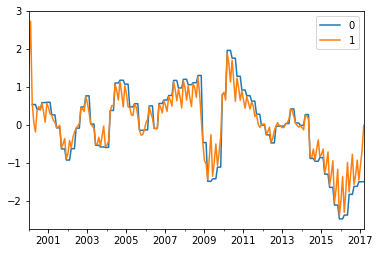

time: 264 ms


In [46]:
smoothGdp = pd.DataFrame(res['yhat'])[20]

smoothGdp.index = y.iloc[20].index
gdp = y.iloc[20].fillna(method='ffill')

pd.concat([gdp,smoothGdp],ignore_index=True,axis=1).plot()

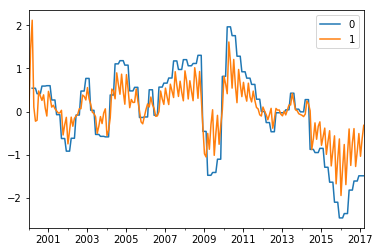

time: 253 ms


In [47]:
smoothGdp = pd.DataFrame(res2['yhat'])[20]

smoothGdp.index = y.iloc[20].index
gdp = y.iloc[20].fillna(method='ffill')

pd.concat([gdp,smoothGdp],ignore_index=True,axis=1).plot()

In [48]:
# minimize(wrapper,coefs, 
#          args=(Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(), coefsIndex),
# #          args={'Z':Z.copy(),'T':T.copy(),'Q':Q.copy(),'H':H.copy(),'R':R.copy(),'y':y.copy()},
# #          options={'disp':True, 'maxiter':1000}, 
# #          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
# #          method='SLSQP',
# #          method='Powell', #mudou algo mas deu tudo igual
#          method='BFGS',
# #          method='Nelder-Mead',
# #          method='CG',
# #          method='L-BFGS-B',
# #          method='TNC',
# #          method='COBYLA',
#          )

time: 2.01 ms


# EM ?

# Bayesian

## Priors

In [49]:
priorsTable = pd.read_excel("PriorsTable.xlsx")
priorsTable.tail()

,distribution,mean,variance,randomWalkVariance
Q_26,Chi,1,NaN,0.001
Q_27,Chi,1,NaN,0.001
Q_28,Chi,1,NaN,0.001
Q_29,Chi,1,NaN,0.001
H_diag,Chi,1,NaN,0.001


time: 28.1 ms


## Posterior

OBS: the posterior already returns log-values

In [50]:
def getPdfValue(value,dist,mean,variance):
    if dist == "Normal":
        return norm.pdf(value,mean,variance)
    if dist == "Chi":
        return chi2.pdf(value,mean)
    
def posteriori(priorsTable,theta,Z, T, Q, H, R,y, coefsIndex):
    
    # OBS: RETURNS THE LOG VALUE
    
    post = 0
    for i in range(0,priorsTable.shape[0]):
#         print(theta[i])
#         print(priorsTable.iloc[i])
#         print(getPdfValue(value = theta[i],
#                             dist = priorsTable.iloc[i]["distribution"],
#                             mean = priorsTable.iloc[i]["mean"],
#                             variance = priorsTable.iloc[i]["variance"],))
        
        post += np.log(getPdfValue(value = theta[i],
                            dist = priorsTable.iloc[i]["distribution"],
                            mean = priorsTable.iloc[i]["mean"],
                            variance = priorsTable.iloc[i]["variance"],))
        
#     ll = wrapper(coefs,Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(),coefsIndex)['ll']
    ll = wrapper2(theta,Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(),coefsIndex)['ll']
#     ll = wrapper3(coefs,Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(),coefsIndex)
#     print(ll)
#     ll = ll['ll']
#     return ll
    
    #     ll = np.exp(ll/1000)
#     ll = np.exp(ll)
#     print(post)
    return post + ll

    
    

time: 18.1 ms


## Metropolis-Hastings

Remember that it's all in log !

In [51]:
posteriori(priorsTable,coefs,Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(),coefsIndex) 

-7484.6685070465637

time: 699 ms


In [52]:
posteriori(priorsTable,coefs,Z.copy(), T.copy(), Q.copy(), H.copy(), R.copy(), y.copy(),coefsIndex) 

-7484.6685070465637

time: 714 ms


In [53]:
def MH(priorsTable,Z, T, Q, H, R,y, coefsIndex, n):
    
    coefs = []
    
    alphaPostValues = np.zeros(n)
    
    accept = np.zeros(n)
    
    initialCoefs = pd.Series(0.1,index=coefsIndex)
    
    
    
    # Tentativa de fazer com transformacao exponencial
    initialCoefs[priorsTable["distribution"]=='Chi'] = np.log(0.1)
    
    temp = initialCoefs.copy()
    
    temp[priorsTable["distribution"]=='Chi'] = np.exp(temp)[priorsTable["distribution"]=='Chi']
    
    lastLogPost = posteriori(priorsTable,temp,Z, T, Q, H, R,y, coefsIndex)
    
    
    
#     lastLogPost = posteriori(priorsTable,initialCoefs,Z, T, Q, H, R,y, coefsIndex)
    
#     print(lastLogPost)
    
    alphaPostValues[0] = lastLogPost
    
    coefs.append(initialCoefs)
    
    disturbances = []
    
    for i in range(1,n):
    
        disturbance = np.multiply(np.random.randn(coefsIndex.shape[0]),
                                      priorsTable["randomWalkVariance"])
        
        
        
        disturbances.append(disturbance)
        
        temp = coefs[i-1] + disturbance
        
        temp2 = temp.copy()
        
        temp2[priorsTable["distribution"]=='Chi'] = np.exp(temp2)[priorsTable["distribution"]=='Chi']
        
        newLogPost = posteriori(priorsTable,temp2,Z, T, Q, H, R,y, coefsIndex)
        
#         disturbance[priorsTable["distribution"]=='Chi'] = np.exp(disturbance)[priorsTable["distribution"]=='Chi']
        
#         temp = coefs[i-1] + disturbance
        
#         temp2 = temp
        
#         temp2[priorsTable["distribution"]=='Chi'] = np.exp(temp)[priorsTable["distribution"]=='Chi']
        
#         newLogPost = posteriori(priorsTable,temp2,Z, T, Q, H, R,y, coefsIndex)
        
#         print(newLogPost)
        
        alphaPostValues[i] = newLogPost
        
        logAlpha = newLogPost - lastLogPost
        
#         print(logAlpha)
        
        alpha = np.exp(logAlpha)
        
#         print(alpha)
        
        r = np.min([1, alpha])
        
        u = np.random.uniform()

        if u < r:
#             print('pos')
            accept[i] = 1
            lastLogPost = newLogPost
            coefs.append(temp)
        else:
#             print('no')
            accept[i] = 0
            coefs.append(coefs[i-1])
#             coefs.append(temp)
    
    coefs = pd.DataFrame(coefs)
    
    coefs = coefs.T
    coefs[priorsTable["distribution"]=='Chi'] = np.exp(coefs)[priorsTable["distribution"]=='Chi']
    coefs = coefs.T
    
    return {
        'posterior' : coefs,
        'posteriorValues' : pd.DataFrame(alphaPostValues),
#         'posterior' : post[burn:], 
#             'post'
        'accept' : accept, 
        'disturbances' : pd.DataFrame(disturbances),
#            'rs' : pd.DataFrame(rs),
#            'priors': pd.DataFrame(priors)}
        }
        

time: 76.2 ms


In [54]:
n = 500
teste = MH(priorsTable,Z, T, Q, H, R,y, coefsIndex, n)


time: 5min 42s


In [55]:
# teste['posterior']
# teste['posteriorValues']
# teste['disturbances']

time: 1 ms


In [56]:
teste['accept'].sum() / teste['accept'].shape[0] * 100

28.999999999999996

time: 12 ms


# Histograms

In [57]:
teste['posterior'].columns.shape

(74,)

time: 5.01 ms


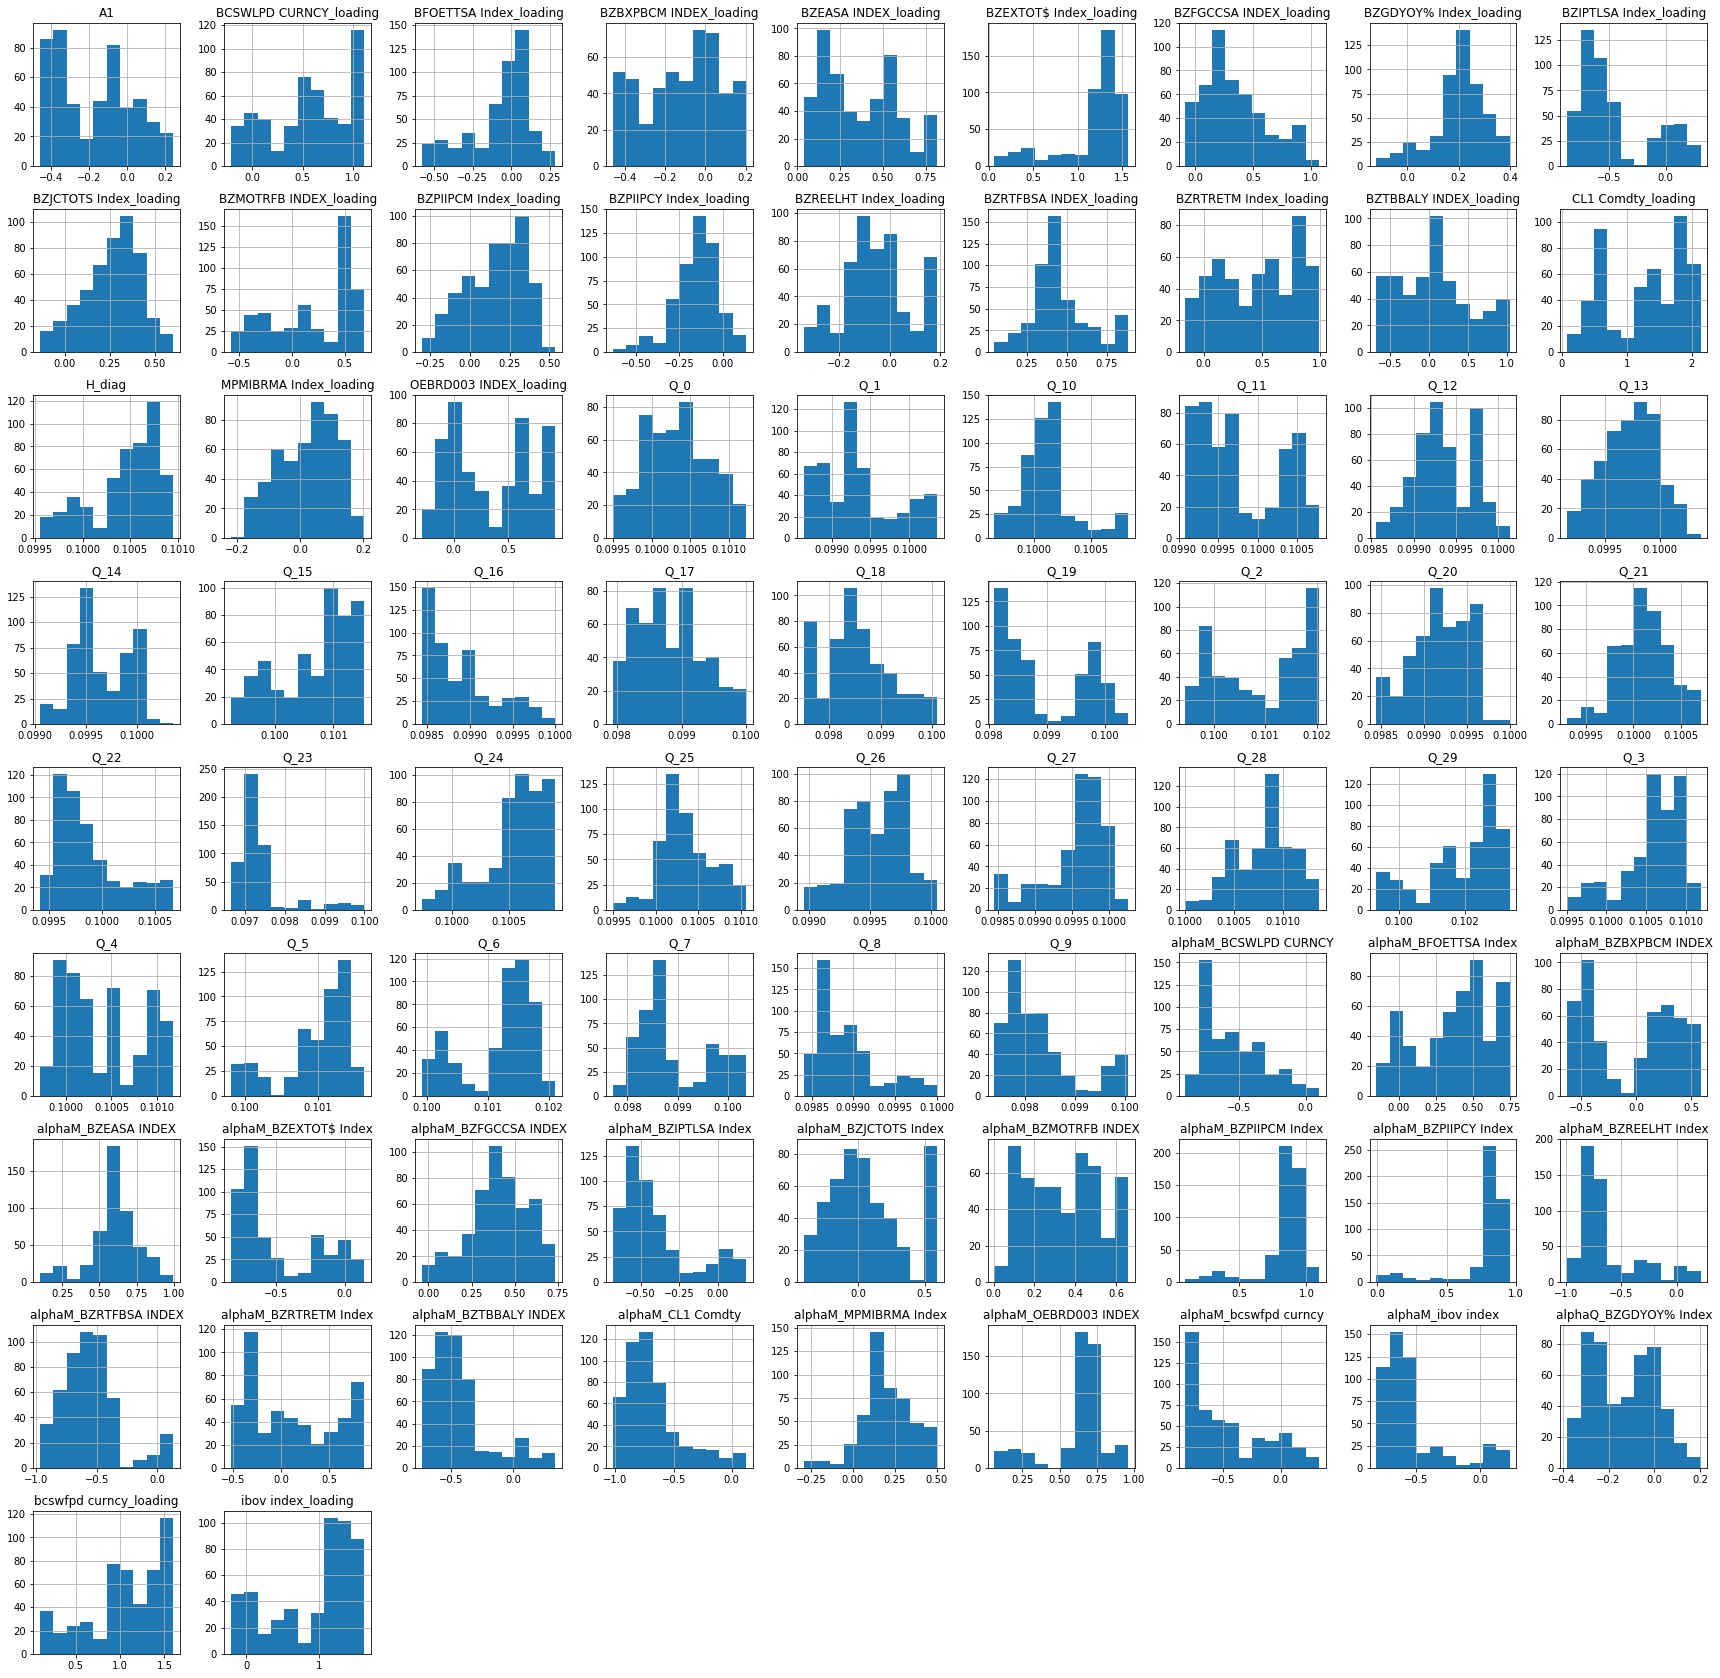

time: 13.7 s


In [58]:
teste['posterior'].hist(figsize=(30,30))
plt.savefig('hist.png')

In [59]:
median = teste['posterior'].rolling(window=100).median()

time: 27.1 ms


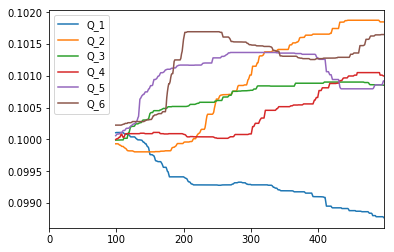

time: 321 ms


In [60]:
median.T.iloc[44:50].T.plot()

# Performance Test

Has to be done in a python file, so we'll first dump the necessary tables and copy the relevant functions

In [457]:
# dump these variables
# n = 500
# teste = MH(priorsTable,Z, T, Q, H, R,y, coefsIndex, n)

priorsTable.to_pickle('./PerformanceTestPickles/priorsTable')
Z.to_pickle('./PerformanceTestPickles/Z')
T.to_pickle('./PerformanceTestPickles/T')
Q.to_pickle('./PerformanceTestPickles/Q')
H.to_pickle('./PerformanceTestPickles/H')
R.to_pickle('./PerformanceTestPickles/R')
y.to_pickle('./PerformanceTestPickles/y')
pd.Series(coefsIndex).to_pickle('./PerformanceTestPickles/coefsIndex')

time: 100 ms


# Estimation without initial values

In [32]:
Zi = Z.as_matrix().T.flatten()
Bi = B.as_matrix().T.flatten()
Qi = Q.as_matrix().T.flatten()
yi = y.as_matrix()

In [33]:
B.shape

(30, 30)

In [34]:
Z.shape

(21, 30)

In [35]:
y.shape

(21, 207)

In [36]:
Q.shape

(30, 30)

In [37]:
# %%R -i Zi,Bi,yi,Z,Qi,m,n

# print(dim(Zi))
# Zi=matrix(Zi,n,m)
# Bi=matrix(Bi,m,m)
# Qi=matrix(Qi,m,m)

# print(dim(Zi))
# print(dim(Bi))
# print(dim(Qi))


# model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero",x0="zero",U="zero")

# kemfit = MARSS(yi, model=model.gen,control=list(minit=1,maxit=2,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
# # kemfit = MARSS(yi, model=model.gen)

# # states = kemfit$states
# states = print(kemfit, what="model")
# # message(kemfit, what="model")
# # print(kemfit, what="start")
# # print(kemfit, what="states")
# # print(kemfit, what="ytT")
# # print(kemfit, what="states.se")
# # print(kemfit, what="kfs")
# # print(kemfit$par$Z)
# # message("porra")
# # states=""
# # cat("teste")

In [38]:
print(dt.datetime.now())

2017-08-02 15:32:33.884102


# Initial Values

## PCA

In [39]:
n_components=1
pca = PCA(n_components=n_components)
components = pca.fit_transform(y.transpose().fillna(0))
components = pd.DataFrame(components)
# components.set_index(data[balancedIndex].index, inplace=True)

print(pca.explained_variance_ratio_) 

[ 0.22680384]


In [40]:
components.set_index(y.transpose().index,inplace=True)
components.shape

(207, 1)

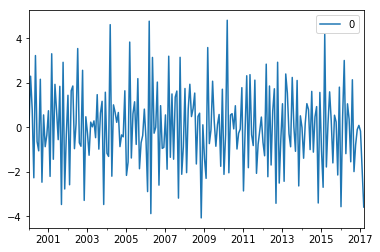

In [41]:
pd.DataFrame(components).plot()

# ARMA Order Estimation

In [49]:
lagsLabels = [
#     "(0,0)",
    "(1,0)","(1,1)","(2,1)","(2,2)",]

aic = []
bic = []

# form = (0,0)
# aic.append(sm.tsa.ARMA(components.dropna(),form).fit().aic)
# bic.append(sm.tsa.ARMA(components.dropna(),form).fit().bic)

form = (1,0)
aic.append(sm.tsa.ARMA(components.dropna(),form).fit().aic)
bic.append(sm.tsa.ARMA(components.dropna(),form).fit().bic)

form = (1,1)
aic.append(sm.tsa.ARMA(components.dropna(),form).fit().aic)
bic.append(sm.tsa.ARMA(components.dropna(),form).fit().bic)

form = (2,1)
aic.append(sm.tsa.ARMA(components.dropna(),form).fit().aic)
bic.append(sm.tsa.ARMA(components.dropna(),form).fit().bic)

form = (2,2)
aic.append(sm.tsa.ARMA(components.dropna(),form).fit().aic)
bic.append(sm.tsa.ARMA(components.dropna(),form).fit().bic)

In [50]:
results = pd.DataFrame()
results["AIC"] = aic
results["BIC"] = bic
results.index = lagsLabels

results

,AIC,BIC
"(1,0)",771.560456,781.558613
"(1,1)",762.770748,776.101623
"(2,1)",722.164483,738.828077
"(2,2)",723.965573,743.961885


## OLS for $\Lambda$ estimation

In [44]:
data.head()

,BZIPTLSA Index,MPMIBRMA Index,BFOETTSA Index,BZREELHT Index,BZPIIPCY Index,BZPIIPCM Index,BZEXTOT$ Index,BZTBBALY INDEX,BZBXPBCM INDEX,BZRTFBSA INDEX,BZFGCCSA INDEX,ibov index,CL1 Comdty,BCSWLPD CURNCY,bcswfpd curncy,BZMOTRFB INDEX,BZJCTOTS Index,BZEASA INDEX,OEBRD003 INDEX,BZRTRETM Index
2000-01-31,NaN,NaN,NaN,NaN,NaN,0.207984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,NaN,NaN,NaN,-1.722609,-1.065146,1.327472,NaN,NaN,0.390218,NaN,1.411873,0.972554,NaN,0.975459,NaN,NaN,NaN,0.877678,0.943908
2000-03-31,NaN,NaN,NaN,NaN,-1.852841,-0.831306,0.575209,NaN,NaN,-0.140217,NaN,0.018289,1.251490,NaN,-0.221743,NaN,NaN,NaN,0.864601,0.635020
2000-04-30,NaN,NaN,NaN,NaN,-0.281467,-0.311661,-0.578823,NaN,NaN,-1.704449,NaN,-1.021657,-1.955820,NaN,-1.030243,NaN,NaN,NaN,-0.607665,-0.497568
2000-05-31,NaN,NaN,NaN,NaN,-0.630297,-1.376933,1.434403,1.128881,NaN,1.157650,NaN,1.276000,1.466675,NaN,2.208863,NaN,NaN,NaN,0.531890,0.635020


In [45]:
def cleanData(df1,df2):
    df = pd.concat([df1, df2],axis=1)
    return df.dropna(axis=0)

In [46]:
coefList = []
for s in data.columns:
    print(s)
    clean = cleanData(data[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])
for s in dataQ.columns:
    clean = cleanData(dataQ[s],components)
    coefList.append(sm.OLS(clean[s],clean[0]).fit().params[0])    

BZIPTLSA Index
MPMIBRMA Index
BFOETTSA Index
BZREELHT Index
BZPIIPCY Index
BZPIIPCM Index
BZEXTOT$ Index
BZTBBALY INDEX
BZBXPBCM INDEX
BZRTFBSA INDEX
BZFGCCSA INDEX
ibov index
CL1 Comdty
BCSWLPD CURNCY
bcswfpd curncy
BZMOTRFB INDEX
BZJCTOTS Index
BZEASA INDEX
OEBRD003 INDEX
BZRTRETM Index


In [47]:
lambda0 = pd.DataFrame(coefList)

## AR for $A$ estimation

In [48]:
A0 = coefList.append(sm.tsa.ARMA(components.dropna(),(1,0)).fit().params[1])


In [49]:
# Z0 = Z
# Z0[0] = lambda0
# Z0.iloc[-1,1] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,2] = 3 * Z0.iloc[-1,0]
# Z0.iloc[-1,3] = 2 * Z0.iloc[-1,0]
# Z0.iloc[-1,4] = 1 * Z0.iloc[-1,0]

# Z0 = Z0.apply(pd.to_numeric,axis=1)
# Z0 = Z0.apply(pd.to_numeric,axis=0)

# Estimation With Initial Values

In [50]:
#  Spent a lot of time struggling here. 
# the size of the Z0 is actually the size of the non fixed parameters
Z0 = lambda0
Z0 = Z0.apply(pd.to_numeric,axis=1)
Z0 = Z0.apply(pd.to_numeric,axis=0)

# Next two lines are only useful when the restriction is effective
Z0 = Z0 * (1/Z0.iloc[0,0]) 
Z0.drop(0,axis=0,inplace=True)

Z0

,0
1,49.165402
2,-34.522394
3,70.274074
4,3.445630
5,19.184319
6,-230.118686
7,-54.760488
8,-134.916276
9,-19.424094
10,43.463345


In [51]:
x0i = np.zeros((m,1))
x0i[0,0] = components[0][0]
x0i = pd.DataFrame(x0i)
x0i

,0
0,-0.006859
1,0.000000
2,0.000000
3,0.000000
4,0.000000
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


In [52]:
Z0i = Z0.as_matrix().T.flatten()

In [53]:
x0i = x0i.as_matrix().flatten()

In [54]:
def runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,maxit):
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
prediction = predict(kemfit,n.ahead=10,se.fit=FALSE)
print(attributes(prediction))

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
#     dic = {}
#     dic[]'vintage'} = yi
    return robjects.r.prediction

In [55]:
# pred = runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,5)

In [56]:
# robjects.r['states1']
# robjects.r('attributes(prediction)')

In [57]:
# robjects.r('print(prediction$method)')

In [58]:
print(dt.datetime.now())

2017-06-10 18:23:50.124013


In [59]:
# iters = [20,50,100,150,300,500,1000]
# # iters = [20,50,100,150]
# # iters = [20,50,100]
# stateslist = []
# for i in iters:
#     stateslist.append(runModel(Zi,Bi,Qi,yi,n,m,Z0i,x0i,i))
#     print("done {maxiters}".format(maxiters=i))
#     print(dt.datetime.now())

In [60]:
print(dt.datetime.now())

2017-06-10 18:23:50.983538


* x0 - Done
* normalizar as séries antes - fazer o check. data.mean e etc
* Initial MC - Bug

In [61]:
# finalList = []
# for state in stateslist: 
#     finalList.append(pd.DataFrame(state).T)
# # stateslist[0]

## Check convergence

In [62]:
def runModel2(Zi,Bi,Qi,y,n,m,Z0i,x0i,maxit):
    yi = y.T.as_matrix()
    robjects.globalenv['Zi'] = Zi
    robjects.globalenv['Bi'] = Bi
    robjects.globalenv['Qi'] = Qi
    robjects.globalenv['yi'] = yi
    robjects.globalenv['n'] = n
    robjects.globalenv['m'] = m
    robjects.globalenv['Z0i'] = Z0i
    robjects.globalenv['x0i'] = x0i
    rcode=("""
Zi=matrix(Zi,n,m)
x0i=matrix(x0i,m,1)
Bi=matrix(Bi,m,m)
Qi=matrix(Qi,m,m)

# Z0i=matrix(Z0i,n,1)
Z0i=matrix(Z0i,n-1,1) # Use this when the restriction is effective

model.gen=list(Z=Zi,B=Bi,Q=Qi,A="zero"
               ,x0=x0i
#                ,x0="zero"
               ,U="zero"
               ,R="diagonal and equal")


inits = list(Z=Z0i,x0=0)
# print(Z0i)
# print(Zi)
# kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(maxit=5,
#                                                 conv.test.slope.tol=0.00001,
#                                                 abstol=0.00001))
kemfit = MARSS(yi, model=model.gen,inits=inits,control=list(minit=1,maxit={maxit!s}
#                                                 conv.test.slope.tol=0.3
#                                                 abstol=0.5, 
#                                                 allow.degen=TRUE
#                                                 MCInit=TRUE,
#                                                 numInits=100,
#                                                 numInitSteps=20
                                                           ))
states1 = kemfit$states
states2 = kemfit$ytT
kfit = print(kemfit)

""").format(maxit=maxit)
    
#     print(rcode)
    
    robjects.r(rcode)
    dic = {}
    dic['vintage' ]= y
    dic['states'] = pd.DataFrame(robjects.r.states1).T
#     print(robjects.r.states1)
    dic['prediction'] = pd.DataFrame(robjects.r('print(kemfit,what=\'ytT\')')).T
    dic['prediction'].index = y.index
    dic['prediction'].columns = y.columns
    dic['message'] = robjects.r.kfit
    return dic

In [63]:
# robjects.r('print(kemfit$errors)')
# print(robjects.r.kfit)

In [64]:
# listOfIters = [5, 10, 30, 50, 100, 150,500,1000]
# # For Each pubdate
# listOfResultsConv = {}
# for iterN in listOfIters:
#     print(iterN)
#     listOfResultsConv[iterN] = runModel2(Zi,Bi,Qi,y.T,n,m,Z0i,x0i,iterN)
   
    
# pickle.dump(listOfResultsConv, open(picklesDir + "Convergence.pickle", "wb"))

In [65]:
# ((listOfResultsConv[100]['states'].T.loc[0]) - (listOfResultsConv[5]['states'].T.loc[0])).hist()

In [66]:
# ((listOfResultsConv[100]['states'].T.loc[0]) - (listOfResultsConv[5]['states'].T.loc[0])).describe()

In [67]:
# (listOfResultsConv[150]['states'].T.loc[0]).describe()

## Stylised Calendar

In [68]:
yn = y.T
calendar = pd.read_excel("Nowcasting.xlsx",sheetname=dataDetailsSheet)
calendar = calendar[["Code","PubLag"]]
calendar.set_index("Code",inplace=True)

In [69]:
# Goal Create publicationDates as another index on the DF

newDfs = []

# For each Series
for serie in yn.columns:
#     Create new df
    newDf = pd.DataFrame(yn[serie])
    newDf.reset_index(inplace=True)
    cols = list(newDf.columns)
    cols[0] = "refDate"
    newDf.columns = cols
    newDf["pubDate"] = newDf["refDate"] + dt.timedelta(int(calendar.loc[serie]))
    newDf.set_index(["refDate","pubDate"],inplace=True)
    newDfs.append(newDf)

yn = pd.concat(newDfs,axis=1)
yn = yn.groupby(level="refDate").fillna(method='ffill')

In [70]:
# Goal: create stylised calendar for all info
pubDates = yn.index.get_level_values("pubDate").unique().sort_values()

In [71]:
np.where(pubDates==dt.datetime(2014,5,1))

(array([2315]),)

# Loop !

In [72]:
maxiter = 300

In [73]:
print(dt.datetime.now())

2017-06-10 18:24:06.042314


In [74]:
def loadDf(pubDate):
    filename = picklesDir + pubDate.strftime('%Y-%m-%d') + ".pickle"
    return pickle.load(open(filename, "rb"))

In [75]:
# For Each pubdate
listOfResults = {}
for pubDate in pubDates[13:]:
#     print(pubDate)
    cutY = yn[yn.index.get_level_values("pubDate")<=pubDate].groupby(level="refDate").last()
    cutY = cutY.reindex(y.T.index)
    filename = picklesDir + pubDate.strftime('%Y-%m-%d') + ".pickle"
    if os.path.exists(filename):
#         print("Exists")
#         listOfResults[pubDate] = pickle.load(open(filename, "rb"))
#         print("Loaded")
        None
    else:
        print(pubDate)
#         print("Does not exist")
        listOfResults[pubDate] = runModel2(Zi,Bi,Qi,cutY,n,m,Z0i,x0i,5)
#         listOfResults[pubDate].to_pickle(filename)
        pickle.dump(listOfResults[pubDate], open(filename, "wb"))
#         print("Dumped")
#     print("Loop Finished")
    
# Still have to find a way to locate everytime a given series enters the dataset    

In [76]:
print(dt.datetime.now())

2017-06-10 18:24:14.467593


Notes:
   
* BCB reports YoY so we have to analise YoY

# Charts

## RMSFE chart

We'll get GDP dates and infer from ``listOfResults``'s keys which vintage corresponds to -X from the GDP pubDate 

So if I want -9, for each GDP published I'll find the -9 vintage and calculate the prediction error

In [77]:
#  Find GDP's publication dates
gdp = yn[gdpTicker]
# .groupby(level="refDate",group_keys=True).last()

gdp = gdp[~gdp.isnull()]

gdpDates = gdp.index.get_level_values("refDate")
# gdpDates

In [78]:
# vintages = pd.Series(list(listOfResults.keys())).sort_values().reset_index(drop=True)
vintages = pubDates[5:]
# vintages

In [79]:
# vintagesOfInterest = {}
# vintagesOfInterest[pubDates[8]]= vintages[(vintages - pubDates[8])<= dt.timedelta(-9)].max()


In [80]:
listOfAxis = [-30, -20, -10, 0, 10, 20, 30]
listOfAxis = range(-200,70, 10)
listOfAxis = range(-70,70,10)
# listOfAxis = range(-70,70,10)
listOfAxis = range(-70,70)
# listOfAxis = [-30]
# listOfAxis = np.arange(-70,70,10).tolist()

In [81]:
gdpDates[6]

Timestamp('2001-09-30 00:00:00')

In [82]:
gdpDates[-1]

Timestamp('2016-12-31 00:00:00')

In [83]:
rmsfe = {}
nowcasts = {}
gdpSerie = {}
start = 6
# end = -13
end = -1

for sieve in listOfAxis:
    vintagesOfInterest = {}
    tempList = []
    tempList2 = []
    tempList3 = []
    for gdpDate in gdpDates[start:end]:
        vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
        actualGdp = gdp.groupby(level="refDate").last()
        actualGdp = actualGdp.loc[gdpDate]
        
        # Loaded Version
#         forecast = listOfResults[vintagesOfInterest[gdpDate]]['prediction'][gdpTicker]
        #Load Version
        forecast = loadDf(vintagesOfInterest[gdpDate])['prediction'][gdpTicker]
        
        forecast = forecast.loc[gdpDate]
        tempList.append((forecast-actualGdp)**2)
        tempList2.append((forecast))
        tempList3.append((actualGdp))
    rmsfe[sieve] = tempList
    nowcasts[sieve] = tempList2
    gdpSerie[sieve] = tempList3

#     rmsfe[sieve] = 

rmsfe = pd.DataFrame(rmsfe).T
nowcasts = pd.DataFrame(nowcasts).T
gdpSerie = pd.DataFrame(gdpSerie).T

nowcastRmsfe = rmsfe.mean(axis=1)

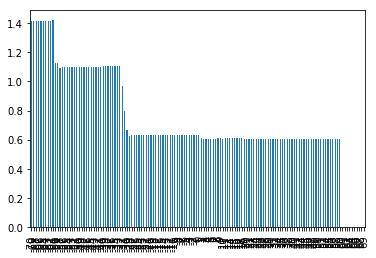

In [84]:
rmsfe.mean(axis=1).plot.bar()
# rmsfe.mean(axis=1).plot()

In [85]:
chartSieve = 30
dat = pd.concat([rmsfe.loc[chartSieve],nowcasts.loc[chartSieve],gdpSerie.loc[chartSieve], ],axis=1)
dat.columns = ["rmsfe","nowcasts","gdpSerie",]
dat.set_index(gdpDates[start:end],inplace=True)
dat.head()

,rmsfe,nowcasts,gdpSerie
refDate,,,
2001-09-30,0.363801,-0.022200,-0.625359
2001-12-31,0.053773,-0.686556,-0.918447
2002-03-31,0.146953,-1.002783,-0.619438
2002-06-30,0.446153,-0.748576,-0.080630
2002-09-30,0.143973,0.096504,0.475942


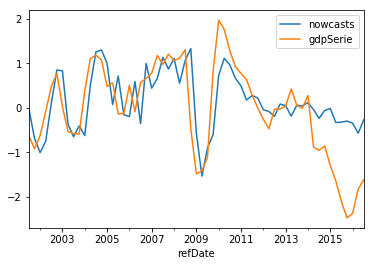

In [86]:
dat[["nowcasts","gdpSerie",]].plot()

### Load BCB Expectation

In [125]:
def last_day_of_month(any_day):
    next_month = any_day.replace(day=28) + dt.timedelta(days=4)  # this will never fail
    return next_month - dt.timedelta(days=next_month.day)

In [126]:
bcb = pd.read_pickle("BCB.pickle")

In [127]:
# bcb["RefDate"] = bcb.index.get_level_values(0)
# bcb["Date"] = bcb.index.get_level_values(1)
bcb = bcb.reset_index()

In [128]:
def subDate(row):
    return row["Date"] - row["ReferenceDate"]

bcb["TimeDelta"] = bcb.apply(subDate, axis=1)
bcb["ReferenceDate"] = bcb["ReferenceDate"].apply(last_day_of_month)
bcb = bcb.set_index(["ReferenceDate","TimeDelta"])
bcb.head()  

Date  BCB_Nowcast
ReferenceDate TimeDelta                        
2001-09-30    66 days   2001-11-06         0.74
              67 days   2001-11-07         0.70
              68 days   2001-11-08         0.67
              69 days   2001-11-09         0.67
              72 days   2001-11-12         0.67

In [129]:
bcb["BCB_Nowcast"] = bcb["BCB_Nowcast"] - mu.loc[gdpTicker] + 1.9
bcb["BCB_Nowcast"] = bcb["BCB_Nowcast"] / sigma.loc[gdpTicker] 

In [130]:
rmsfeBcb = {}
bcbNowcast = {}

for sieve in listOfAxis:
    vintagesOfInterest = {}
    tempList = []
    tempList2 = []
    for gdpDate in gdpDates[start:end]:
        if gdpDate in list(bcb.index.get_level_values(0).unique()):
            vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
            actualGdp = gdp.groupby(level="refDate").last()
            actualGdp = actualGdp.loc[gdpDate]
#             print(gdpDate)
            forecast = bcb.loc[gdpDate].loc[:dt.timedelta(sieve)]
            if forecast.shape[0] > 0:
                forecast = forecast.iloc[-1]["BCB_Nowcast"]
            else:
                forecast = 0
#             forecast = forecast.loc[gdpDate]
            tempList.append((forecast-actualGdp)**2)
            tempList2.append((forecast))
#             print("aqui")
#         else:
#             print(gdpDate)
    rmsfeBcb[sieve] = tempList
    bcbNowcast[sieve] = tempList2

#     rmsfe[sieve] = 

bcbNowcast = pd.DataFrame(bcbNowcast).T
rmsfeBcb = pd.DataFrame(rmsfeBcb).T





bcbRmsfe = rmsfeBcb.mean(axis=1)


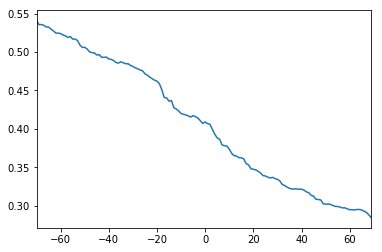

In [131]:
# rmsfeBcb[30].plot()
bcbRmsfe.plot()

In [132]:
rmsfeBcbN = pd.DataFrame(rmsfeBcb.loc[chartSieve])
rmsfeBcbN.set_index(gdpDates[start:end],inplace=True)

bcnow = pd.DataFrame(bcbNowcast.loc[chartSieve])
bcnow.set_index(gdpDates[start:end],inplace=True)

dat2 = pd.concat([dat,bcnow, rmsfeBcbN,],axis=1)
dat2.columns = ["rmsfe","nowcasts","gdpSerie","bcbNowcast","rmsfeBcb",]

dat2.head()

,rmsfe,nowcasts,gdpSerie,bcbNowcast,rmsfeBcb
refDate,,,,,
2001-09-30,0.363801,-0.022200,-0.625359,0.000000,0.391074
2001-12-31,0.053773,-0.686556,-0.918447,-0.113195,0.648431
2002-03-31,0.146953,-1.002783,-0.619438,-0.178326,0.194580
2002-06-30,0.446153,-0.748576,-0.080630,0.304233,0.148120
2002-09-30,0.143973,0.096504,0.475942,0.393048,0.006871


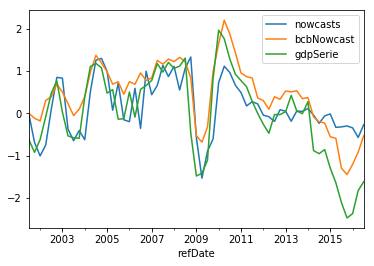

In [133]:
dat2[["nowcasts","bcbNowcast","gdpSerie",]].plot()

# Actual vs Predicted vs BCB Chart

In [134]:
dat2["nowcasts"] = dat2["nowcasts"] * sigma.loc[gdpTicker]
dat2["nowcasts"] = dat2["nowcasts"] + mu.loc[gdpTicker]

In [135]:
dat2["gdpSerie"] = dat2["gdpSerie"] * sigma.loc[gdpTicker]
dat2["gdpSerie"] = dat2["gdpSerie"] + mu.loc[gdpTicker]

In [136]:
dat2["bcbNowcast"] = dat2["bcbNowcast"] * sigma.loc[gdpTicker]
dat2["bcbNowcast"] = dat2["bcbNowcast"] + mu.loc[gdpTicker]

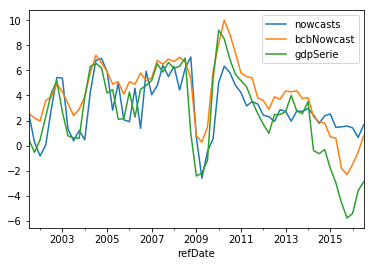

In [137]:
dat2[["nowcasts","bcbNowcast","gdpSerie",]].plot()

# RMSFE Actual vs Predicted vs BCB Chart

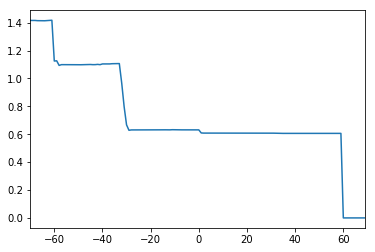

In [138]:
nowcastRmsfe.plot()

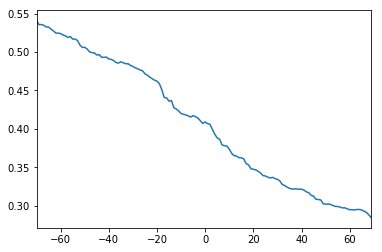

In [139]:
bcbRmsfe.plot()

In [140]:
ls = list(range(-70, 60,10)) #+ [59]
ls

[-70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]

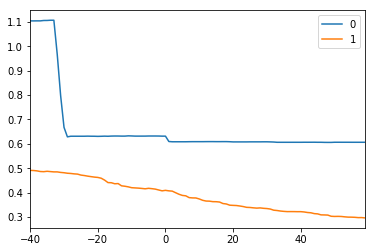

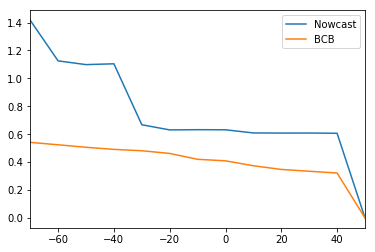

In [141]:
pd.concat([nowcastRmsfe,bcbRmsfe,],axis=1).loc[-40:59].plot()
# x = pd.concat([nowcastRmsfe,bcbRmsfe,],axis=1).loc[:59]
x = pd.concat([nowcastRmsfe,bcbRmsfe,],axis=1)
x.columns = ["Nowcast","BCB"]
x = x.loc[ls]
x.iloc[-1]=0
x.plot()


# AR(1) Model

For each day we'll run an AR model with the available info using the same kind of loop.

In [142]:
rmsfeAr = {}
arNowcast = {}

for sieve in listOfAxis:
    vintagesOfInterest = {}
    tempList = []
    tempList2 = []
    for gdpDate in gdpDates[start:end]:
        if gdpDate in list(bcb.index.get_level_values(0).unique()):
            vintagesOfInterest[gdpDate]= vintages[(vintages - gdpDate)<= dt.timedelta(sieve)].max()
            actualGdp = gdp.groupby(level="refDate").last()
            actualGdp = actualGdp.loc[gdpDate]
#             print(gdpDate)
            
            cutY = yn[yn.index.get_level_values("pubDate")<=vintagesOfInterest[gdpDate]].groupby(level="refDate").last()[gdpTicker].dropna()
            ar = tsa.ar_model.AR(cutY)
            res = ar.fit(maxlag=1)
#             pred = ar.predict(params=res.params, start=1, end=6)
            
            forecast = cutY.iloc[-1] * res.params[1] + res.params[0]
            tempList.append((forecast-actualGdp)**2)
            tempList2.append((forecast))
#             print("aqui")
#         else:
#             print(gdpDate)
    rmsfeAr[sieve] = tempList
    arNowcast[sieve] = tempList2

#     rmsfe[sieve] = 

arNowcast = pd.DataFrame(arNowcast).T
rmsfeAr = pd.DataFrame(rmsfeAr).T





arRmsfe = rmsfeAr.mean(axis=1)

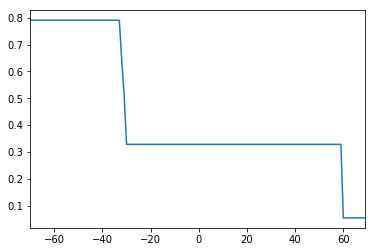

In [143]:
arRmsfe.plot()

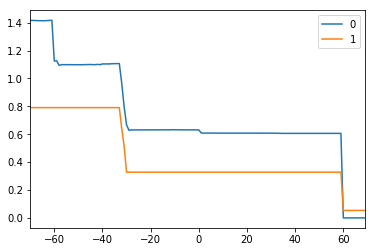

In [144]:
pd.concat([nowcastRmsfe,arRmsfe,],axis=1).plot()

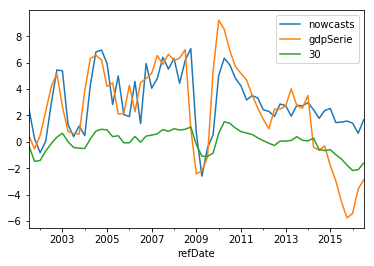

In [145]:
arn = arNowcast.loc[chartSieve]

arn.index = dat2.index
pd.concat([dat2[["nowcasts","gdpSerie"]] ,arn],axis=1).plot()

# Diebold Mariano Test



In [146]:
def ifunc(k,h):
    res = np.abs(k/(h-1))
    if res <=1:
        return 1
    else:
        return 0 
    
def gamma(k,dif,T):
    res = 0
    for t in range(np.abs(k)+1,T):
        res += (dif[t] - dif.mean()) * (dif[t-np.abs(k)] - dif.mean())
    
    return res * 1/T
    

def fhat(h,dif):
    T = dif.shape[0]
    res = 0
    for k in range(-(T-1),T):
        res += gamma(k,dif,T) * ifunc(k,h)
        
    return 1/(2*np.pi) * res

In [147]:
def DMtest(series1,series2,trueSeries,steps=2):
    difNowcast = (series1 - trueSeries) ** 2
    difBcb = (series2 - trueSeries) ** 2 

    dbarra = difNowcast - difBcb
    f = fhat(steps,dbarra)
    dmEstat = dbarra.mean() / (np.sqrt(2*np.pi*f / difBcb.shape[0]))
    p_value = sp.stats.norm.sf(abs(dmEstat))*2
    return {'dm' : dmEstat, 'p-value' : p_value}

In [148]:
def cutDat(chartSieve,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow):

    dat = pd.concat([rmsfe.loc[chartSieve],nowcasts.loc[chartSieve],gdpSerie.loc[chartSieve], ],axis=1)
    dat.columns = ["rmsfe","nowcasts","gdpSerie",]
    dat.set_index(gdpDates[start:end],inplace=True)


    rmsfeBcb = pd.DataFrame(rmsfeBcb.loc[chartSieve])
    rmsfeBcb.set_index(gdpDates[start:end],inplace=True)

    bcnow = pd.DataFrame(bcbNowcast.loc[chartSieve])
    bcnow.set_index(gdpDates[start:end],inplace=True)

    dat2 = pd.concat([dat,bcnow, rmsfeBcb,],axis=1)
    dat2.columns = ["rmsfe","nowcasts","gdpSerie","bcbNowcast","rmsfeBcb",]
    
    dat2["nowcasts"] = dat2["nowcasts"] * sigma.loc[gdpTicker]
    dat2["nowcasts"] = dat2["nowcasts"] + mu.loc[gdpTicker]
    dat2["gdpSerie"] = dat2["gdpSerie"] * sigma.loc[gdpTicker]
    dat2["gdpSerie"] = dat2["gdpSerie"] + mu.loc[gdpTicker]
    dat2["bcbNowcast"] = dat2["bcbNowcast"] * sigma.loc[gdpTicker]
    dat2["bcbNowcast"] = dat2["bcbNowcast"] + mu.loc[gdpTicker]
    return dat2


## DM - Nowcast vs BCB

In [149]:
newDat = cutDat(-60,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"], newDat["bcbNowcast"], newDat["gdpSerie"],3)

{'dm': 2.3545249077791368, 'p-value': 0.018546400707617827}

In [150]:
newDat = cutDat(-30,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],newDat["bcbNowcast"],newDat["gdpSerie"],2)

{'dm': 1.2340701463837778, 'p-value': 0.21717676672848629}

In [151]:
newDat = cutDat(0,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],newDat["bcbNowcast"],newDat["gdpSerie"],2)

{'dm': 1.4494615308237053, 'p-value': 0.14720873597207698}

In [152]:
newDat = cutDat(30,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],newDat["bcbNowcast"],newDat["gdpSerie"],3)

{'dm': 1.6600773387363559, 'p-value': 0.096898895086875214}

In [153]:
newDat = cutDat(59,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],newDat["bcbNowcast"],newDat["gdpSerie"],3)

{'dm': 1.848282033076333, 'p-value': 0.064561553509343714}

## Nowcast vs ar

In [154]:
newDat = cutDat(-60,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],arn,newDat["gdpSerie"],3)

{'dm': -0.28790064715091118, 'p-value': 0.77342279152510651}

In [155]:
newDat = cutDat(-30,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],arn,newDat["gdpSerie"],2)

{'dm': -1.6873301186742815, 'p-value': 0.091539892712281634}

In [156]:
newDat = cutDat(0,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],arn,newDat["gdpSerie"],2)

{'dm': -1.8210236125638424, 'p-value': 0.068603267608139409}

In [157]:
newDat = cutDat(30,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],arn,newDat["gdpSerie"],3)

{'dm': -1.6761591027884086, 'p-value': 0.093707032531273021}

In [158]:
newDat = cutDat(59,rmsfe, nowcasts, gdpSerie, gdpDates, start, end,rmsfeBcb,bcnow)
DMtest(newDat["nowcasts"],arn,newDat["gdpSerie"],3)

{'dm': -1.68407769064065, 'p-value': 0.092166655233993006}

# Monotonicity Tests

Uses MatLab code

In [159]:
# Export actuals
# actuals, a Tx1 vector of realizations for the target variable
dat2["gdpSerie"].to_csv('./Monotonicity/actuals.csv',index=False)

In [160]:
# Export forecasts
# forecasts, a TxH matrix of forecasts, with shortest forecast horizon in first column and longest forecast horizon in last column
nowcasts.T[[-60,-30,0,30]].to_csv('./Monotonicity/forecasts.csv',header = False,index=False)

In [161]:
# OUTPUTS:  out1, a 13x1 vector of p-values for the various tests:
# %                       BOUNDS TESTS USING DATA ON ACTUAL
# %                           1)  INC MSE test
# %                           2)  DEC COV test (covariance between actual and forecast)
# %                           3)  Covariance bound test 1: V[ nu[t|1,h] ] <= 2*Cov[ Y[t], nu[t|1,h] ] for all h>=2
# %
# %                       BOUNDS TESTS USING DATA ONLY ON FORECASTS
# %                           4)  DEC MSF test (mean-squared forecast)
# %                           5)  INC MSFR test (mean-squared forecast revision)
# %                           6)  DEC COV test, using shortest-horizon forecast as proxy for actual
# %                           7)  Covariance bound test 1: V[ nu[t|1,h] ] <= 2*Cov[ Yhat[t|t-1], nu[t|1,h] ] for all h>=3, using shortest-horizon forecast as proxy for actual
# %
# %                       REGRESSION BASED TESTS
# %                           8)  Univar MZ on shortest horizon
# %                           9)  Univar opt revision regression
# %                           10) Univar opt revision regression, with h=1 forecast as proxy
# %
# %                       BONFERRONI COMBINATIONS OF ABOVE TESTS
# %                           11) Bonf using actuals, tests 1, 2, 3, 8, 9
# %                           12) Bonf using forecasts, tests 4, 5, 6, 7, 10
# %                           13) Bonf across all tests, tests 1-10

In [162]:
pd.read_csv('./Monotonicity/out.csv',header=None).iloc[[4,5,6]]

,0
4,0.16447
5,0.43088
6,0.60756
